In [6]:
import math
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from tqdm import tqdm
from nltk import word_tokenize
from scipy.spatial.distance import cosine,euclidean, cityblock

### Mechanical Features - Maxwell-Boltzmann Similarity Measure (MBSM)

* The MBSM consists of the sum of squared difference
of all feature values and total number of non-zero features among
the documents.

* The energy difference of dissimilarity between two documents is used to define the MBSM.

* The difference between question_pairs is given by - 
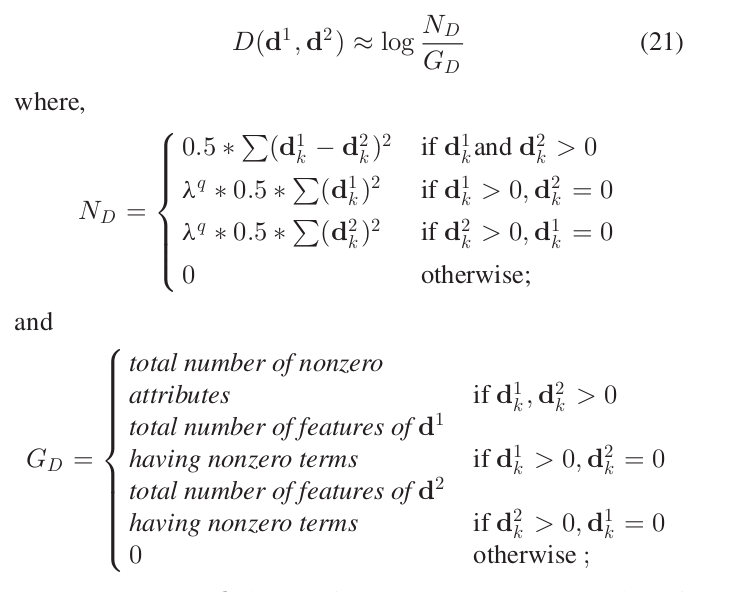


#### Approach

* Find the vectors for both the question_pairs in our dataset.
* Find the difference between the vector pairs of question.
* Find the similarity of our questions for different lambda_values.

* PS - The lambda_values used here signify the importance of present_absent pairs.

In [2]:
class vectors:

    def __init__(self,my_dataframe):
        '''
         my_dataframe : pandas dataframe, all changes made in this dataframe will 
                        reflect back in original one (changes are in_place). 
        '''
        self.my_dataframe = my_dataframe

    def CVec_helper(self,s1,s2):
        '''
         CVec_Helper : Returns the vector of the sentence in the pair
        '''
        corpus = []
        corpus.append(s1)
        corpus.append(s2)
        vectorizer = CountVectorizer(analyzer='word')
        X = vectorizer.fit_transform(corpus)
        return (X.toarray()[0]).tolist(), (X.toarray()[1]).tolist()

    def CVec(self):
        self.my_dataframe['Vectors'] = self.my_dataframe.apply(lambda x: self.CVec_helper(x.question1, x.question2), axis=1)

In [3]:
class similarity:

    def __init__(self,my_dataframe,lambda_val = 0.99):
        '''
         my_dataframe : pandas dataframe, all changes made in this dataframe will 
                        reflect back in original one (changes are in_place). 
        '''
        self.my_dataframe = my_dataframe
        self.lambda_val = lambda_val

    def similarity_helper(self,list1 = [],list2 = []):
        '''
         similarity : returns the similarity score of the two sentences

        '''
        l3 = []
        pre_pre_count  = 0
        pre_abs_count = 0

        for i in range(len(list1)):
            # pre_pre pairs
            if list1[i] and list2[i] > 0: 
                l3.append(1)
                pre_pre_count += 2

            # pre_abs pairs
            elif (list1[i] > 0 and list2[i] == 0) or (list2[i] > 0 and list1[i] == 0): 
                l3.append(2)
                pre_abs_count += 1

            # pre_abs pairs
            else: 
                l3.append(0)

        if not pre_pre_count:
            return 0
        else:
            difference_score = 0
            for i in range(len(l3)):
                if l3[i] == 1: #calculating present-present pairs
                    difference_score = difference_score + 0.5*((list1[i] - list2[i])**2)
                elif l3[i] == 2: #calculating present-absent pairs
                    difference_score  = difference_score + 0.5 * ((math.pow(self.lambda_val,2))*((list1[i] - list2[i])**2))  
        
            difference = math.log(1 + (difference_score/(pre_pre_count + pre_abs_count)))
            similarity  = 1/(1 + difference)
            return similarity
    
    def find_similarity(self):
        self.my_dataframe["mech_sim_{}".format(self.lambda_val)]  = self.my_dataframe.apply(lambda x: self.similarity_helper(x.Vectors[0],x.Vectors[1]), axis=1)           

In [4]:
# Getting the Vectors
train = pd.read_csv("/home/vulcan/Documents/Niggas_TP/text_similarity/text_similarity/data/raw/train.csv",nrows = 5)
train = train.fillna('Undefined')
vc = vectors(train)
vc.CVec()
a = vc.my_dataframe
a.to_pickle("/home/vulcan/Documents/Niggas_TP/text_similarity/text_similarity/notebooks/presen_data/my_csv.pkl") #Saving as pickle

# Finding Similarity Measures
train = pd.read_pickle("/home/vulcan/Documents/Niggas_TP/text_similarity/text_similarity/notebooks/presen_data/my_csv.pkl")
train = train[['id','Vectors']]

lambda_val = [0.99,1.25,1.5,2] #Improve According to a loop

for value in tqdm(lambda_val):
    fs = similarity(train,value)
    fs.find_similarity()
    a = fs.my_dataframe
    a = a[["id","mech_sim_{}".format(value)]]
    a.to_csv("/home/vulcan/Documents/Niggas_TP/text_similarity/text_similarity/notebooks/presen_data/my_csv_similarity_{}".format(value),index = False)

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 207.53it/s]


In [5]:
mf = pd.read_csv('/home/vulcan/Documents/Niggas_TP/text_similarity/text_similarity/data/interim/Final Features.csv',nrows = 5)
df2 = pd.read_csv('/home/vulcan/Documents/Niggas_TP/text_similarity/text_similarity/data/raw/train.csv',nrows = 5)
mf = mf.merge(df2,left_on = 'id' ,right_on = 'id')
mf = mf[['id','question1','question2','mech_sim_0.99','mech_sim_1.25','mech_sim_1.5','mech_sim_2']]
mf.head()

,id,question1,question2,mech_sim_0.99,mech_sim_1.25,mech_sim_1.5,mech_sim_2
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.959559,0.948577,0.936095,0.906467
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0.819996,0.757279,0.700311,0.602968
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0.786511,0.712469,0.649375,0.549155
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0.000000,0.000000,0.000000,0.000000
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0.795063,0.722328,0.659712,0.559141


### Mechanical Word2Vec Similarity - using WordVectors on differenced Question_pairs

#### Approach  

* Reduce the question_pairs to differenced_sets on each question.
* Find the word_vectors for them using GoogleNews word_vectors.
* Find their dissimilarity(euclidean distance).
* Generate several related features using log,sqrt,etc.

In [16]:
#model = gensim.models.KeyedVectors.load_word2vec_format('/home/vulcan/Documents/Niggas_TP/text_similarity/GoogleNews-vectors-negative300.bin', binary=True)
def sent2vec(s):
    M = []
    for w in s.split():
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

In [8]:
class differenced_sent:

    def __init__(self, my_dataframe):
        self.my_dataframe = my_dataframe

    def find_pre_abs(self,s1,s2):
        s1 = set(s1.split())
        s2 = set(s2.split())
        pre_abs = len(s1.difference(s2)) + len(s2.difference(s1)) 
        return pre_abs

    def find_pre_pre(self,s1,s2):
        s1 = set(s1.split())
        s2 = set(s2.split())
        pre_pre = len(s1 & s2)
        return pre_pre


    def find_question(self,s1,s2):
        s1 = set(s1.split())
        s2 = set(s2.split())    
        s1 = ' '.join(list(s1.difference(s2))) 
        return s1    

    def create_features(self):
        self.my_dataframe['pre_pre'] = self.my_dataframe.apply(lambda x: self.find_pre_pre(str(x.question1),str(x.question2)), axis=1)
        self.my_dataframe['pre_abs'] = self.my_dataframe.apply(lambda x: self.find_pre_abs(str(x.question1),str(x.question2)), axis=1)
        self.my_dataframe['question_1'] = self.my_dataframe.apply(lambda x: self.find_question(str(x.question1),str(x.question2)), axis=1)
        self.my_dataframe['question_2'] = self.my_dataframe.apply(lambda x: self.find_question(str(x.question2),str(x.question1)), axis=1)

        self.my_dataframe = self.my_dataframe[['id','question_1','question_2','pre_pre','pre_abs','is_duplicate']]

In [9]:
class mech_measures:
    
    def __init__(self, my_dataframe):
        self.my_dataframe = my_dataframe
        self.question1_vectors = np.zeros((self.my_dataframe.shape[0], 300))
        self.question2_vectors = np.zeros((self.my_dataframe.shape[0], 300))
        
    
    def convert_sentence_to_vector(self):
    
        for i, q in tqdm(enumerate(self.my_dataframe.question_1.values)):
            self.question1_vectors[i, :] = sent2vec(str(q))

        for i, q in tqdm(enumerate(self.my_dataframe.question_2.values)):
            self.question2_vectors[i, :] = sent2vec(str(q))
        

    def euclid_distance(self):
        self.my_dataframe['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(self.question1_vectors),
                                                                       np.nan_to_num(self.question2_vectors))]


In [13]:
def get_features(df):
    df['dissimilarity'] = df['euclidean_distance']**2
    df['diss_pre_abs'] = df['dissimilarity']/(1+ df['pre_abs'])
    df['diss_pre_pre']  = df['dissimilarity']/(1+ df['pre_pre'])
    df['diss'] = df['dissimilarity']/(1 + df['pre_abs'] + df['pre_pre'])
    df['log_diss_pre_abs'] = np.log(df['dissimilarity']/(1+ df['pre_abs']))
    df['log_diss_pre_pre'] = np.log(df['dissimilarity']/(1+ df['pre_pre']))
    df['log_diss'] = np.log(df['dissimilarity']/(1 + df['pre_abs'] + df['pre_pre']))

    df['similarity_1'] = 1/(1 + df['dissimilarity'])
    df['similarity_2'] = 1/(1 + df['diss_pre_abs'])
    df['similarity_3'] = 1/(1 + df['diss_pre_pre'])
    df['similarity_4'] = 1/(1 + df['diss'])
    df['similarity_5'] = 1/(1 + df['log_diss_pre_abs'])
    df['similarity_6'] = 1/(1 + df['log_diss_pre_pre'])
    df['similarity_7'] = 1/(1 + df['log_diss'])

In [15]:
df = pd.read_csv('/home/vulcan/Documents/Niggas_TP/text_similarity/text_similarity/data/processed/mechanical_features.csv',nrows = 5)
df.head()

,id,question_1,question_2,pre_pre,pre_abs,is_duplicate,euclidean_distance,dissimilarity,diss_pre_abs,diss_pre_pre,...,log_diss_pre_abs,log_diss_pre_pre,log_diss,similarity_1,similarity_2,similarity_3,similarity_4,similarity_5,similarity_6,similarity_7
0,0,india,Undefined,5,1,0,1.258383,1.583528,0.791764,0.263921,...,-0.233492,-1.332104,-1.486255,0.387068,0.558109,0.791189,0.815516,1.304618,-3.011101,-2.056533
1,1,story,happen government indian would back steal,4,7,0,1.301034,1.692689,0.211586,0.338538,...,-1.553123,-1.083119,-1.958588,0.371376,0.825364,0.747084,0.876380,-1.807916,-12.030898,-1.043201
2,2,use connection vpn,hack dns,3,5,0,1.101319,1.212903,0.202151,0.303226,...,-1.598743,-1.193277,-2.004208,0.451895,0.831843,0.767327,0.881238,-1.670167,-5.173908,-0.995810
3,3,mentally solve lonely,24 divide 23 find math remainder,0,9,0,1.147563,1.316902,0.131690,1.316902,...,-2.027303,0.275282,-2.027303,0.431611,0.883634,0.431611,0.883634,-0.973423,0.784140,-0.973423
4,4,methane dissolve oxide one carbon di sugar quikly,survive would fish,2,11,0,1.184813,1.403782,0.116982,0.467927,...,-2.145736,-0.759442,-2.299887,0.416011,0.895270,0.681233,0.908868,-0.872801,4.157002,-0.769298
